In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from datasets.carla import *
from tools.utils import *
from tools.loss import *
from models.backbones.midas.midas_net import *
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
cd = compile_data("test", "trainval", "../../data/carla", "all")

In [38]:
model = torch.hub.load("intel-isl/MiDaS", "MiDaS").to(4)
# model = MidasNet.to(4)

opt = torch.optim.Adam(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-7
    )


Using cache found in /home/bny220000/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/bny220000/.cache/torch/hub/facebookresearch_WSL-Images_main


In [39]:
i = 0

for (images, segs, depths, intrinsics, extrinsics, labels, oods) in cd:
    opt.zero_grad(set_to_none=True)

    inv = 1/depths
    inv = inv/inv.max()
    outs = model(images.to(4).view(-1, 3, 224, 480)).unsqueeze(1)
    loss = depth_loss(outs, inv.to(4).view(-1, 1, 224, 480))

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    opt.step()

    if i % 20 == 0:
        print(loss.item())
    i = (i + 1) % 20


207.14266623552567
71.8900717766468
49.58017413462276
32.33811747391452
50.676823990161964
49.046904923441765
24.544838442162877


In [33]:
images, segs, depths, intrinsics, extrinsics, labels, oods = cd.dataset[0]
images = images[None].to(4)
segs = segs[None].to(4)
depths = depths[None].to(4)
intrinsics = intrinsics[None].to(4)
extrinsics = extrinsics[None].to(4)
labels = torch.tensor(labels[None]).to(4)
oods = torch.tensor(oods)[None].to(4)
inv = 1/depths

In [34]:
outs = model(images.to(4).view(-1, 3, 224, 480))[None]

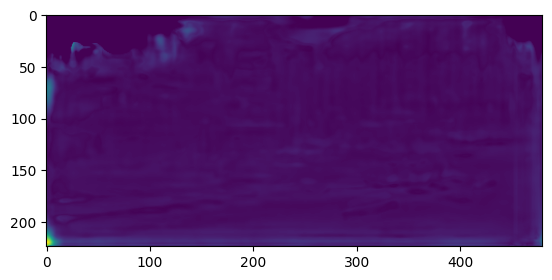

In [36]:
plt.imshow(outs[0, 0].detach().cpu().numpy())

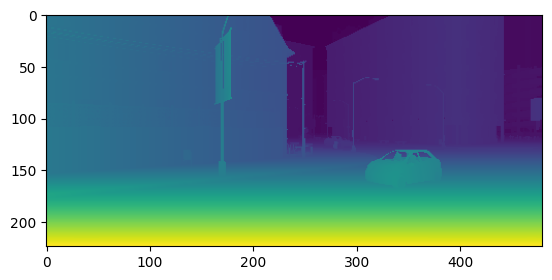

In [27]:
plt.imshow(inv[0, 0].detach().cpu().numpy())